# Perturbations

When performing a numerical simulation studying the onset of instabilities in a time-dependent problem, it is typical to set for the initial conditions

$$u(\textbf{x}, t=0) = u_0(\textbf{x})=b(\textbf{x}) + \mathcal{N}(\textbf{x})$$

$$\min_{\textbf{x}}\mathcal{N}(\textbf{x}) = \varepsilon^-$$
$$\max_{\textbf{x}}\mathcal{N}(\textbf{x}) = \varepsilon^+$$

When adding some numerical noise $\mathcal{N}(\textbf{x})$ to the base state $b(\textbf{x})$, it is desirable to have control of both its amplitude and 'coarseness' or frequency.

In [1]:
import numpy as np
from dolfinx.fem import FunctionSpace
from lucifex.mesh import rectangle_mesh, interval_mesh
from lucifex.utils import SpatialPerturbation, DofsPerturbation, sinusoid_noise, cubic_noise, cross_section
from lucifex.viz import plot_line, plot_colormap

## Examples: $d=1$ interval

$$\Omega = [0, L_x]$$

$$b(x)= 1 - x$$

sinusoid noise with specified frequency and subject to periodic boundary conditions

$$\mathcal{N}(x)=\mathcal{N}_{\text{sinu}}(x;n_{\text{waves}})$$
$$ \mathcal{N}_{\text{sinu}}(x=0)=\mathcal{N}_{\text{sinu}}(x=L_x)=0$$

prescribed noise function

$$\mathcal{N}(x;\lambda_0, \lambda_1)=\cos(2\pi x/\lambda_0)\sin(2\pi x/\lambda_1)$$

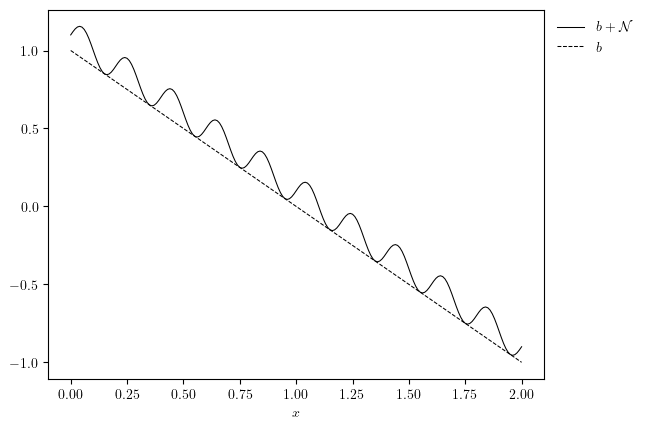

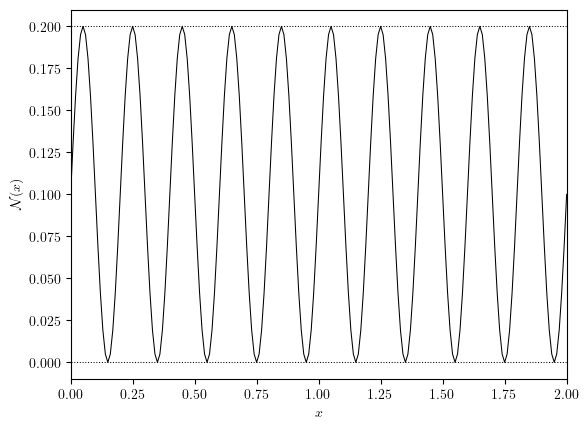

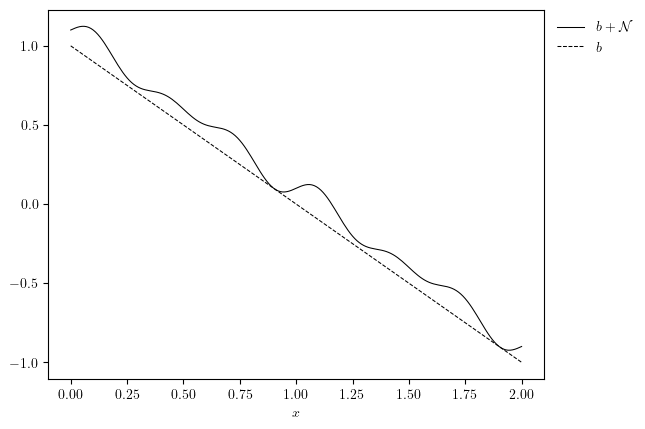

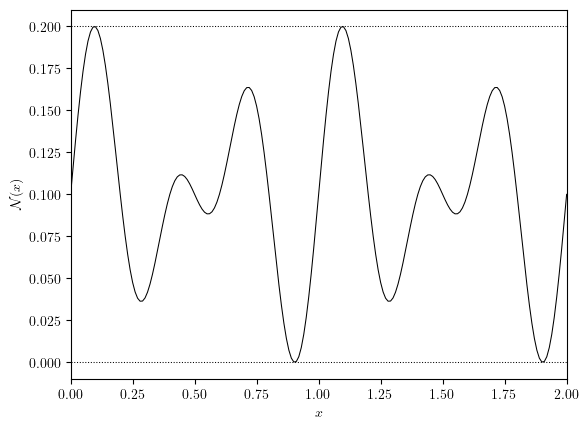

In [2]:
Lx = 2.0
mesh = interval_mesh(Lx, 200)
fs = FunctionSpace(mesh, ('P', 1))

n_waves = 10
sinu_noise = sinusoid_noise('periodic', Lx, n_waves, 0)

lmbda = (Lx, 0.2 * Lx)
sincos_noise = lambda x: np.cos(2* np.pi * x[0] / lmbda[0]) * np.sin(2 * np.pi * x[0] / lmbda[1])

for noise in (sinu_noise, sincos_noise):
    eps = 0.2
    perturbation = SpatialPerturbation(
        lambda x: 1 - x[0],
        noise,
        [Lx],
        eps,
    )    
    u0 = perturbation.combine_base_noise(fs)
    uBase = perturbation.base(fs)
    uNoise = perturbation.noise(fs)
    plot_line([u0, uBase], x_label='$x$', legend_labels=['$u_0=b+\mathcal{N}$', '$b$'])
    fig, ax = plot_line(uNoise, x_label='$x$', y_label='$\mathcal{N}(x)$')
    ax.hlines((0, eps), 0, Lx, colors='black', linestyles='dotted', linewidths=0.75)

## Examples: $d=2$ rectangle

$$\Omega = [0, L_x]\times[0, L_y]$$

$$b(x, y)= \tfrac{1}{2}xy$$

cubic interpolation noise with specified frequency and subject to Neumann/Dirichlet boundary conditions

$$\mathcal{N}(x)=\mathcal{N}_{\text{cubi}}(x;n_{\text{freq}})$$
$$\frac{\partial\mathcal{N}_{\text{cubi}}}{\partial x}(x=0,y)=\frac{\partial\mathcal{N}_{\text{cubic}}}{\partial x}(x=L_x,y)=\mathcal{N}_{\text{cubi}}(x,y=0)=\mathcal{N}_{\text{cubic}}(x,y=L_y)=0$$

degrees-of-freedom vector noise

$$\textbf{u}_0 = \textbf{b} + \textbf{N}\quad\text{where}\quad u_0(\textbf{x})=\sum_ju_{0,j}\xi_j(\textbf{x})$$

In [3]:
Lx = 2.0
Ly = 1.0
mesh = rectangle_mesh(Lx, Ly, 100, 100)
fs = FunctionSpace(mesh, ('P', 1))

base =  lambda x: 0.5 * x[0] * x[1]

eps = (-0.25, 0.5) 
freq = (5, 10)
seed = (11, 22)
noise_perturbation = SpatialPerturbation(
    base,
    cubic_noise(['neumann', 'dirichlet'], [Lx, Ly], freq, seed, (0, 1)),
    [Lx, Ly],
    eps,
)
dofs_perturbation = DofsPerturbation(
    base,
    123,
    eps,
)

min(N) = -0.25
max(N) = 0.4994233082812214
min(N) = -0.2499879345102143
max(N) = 0.49996212192760614


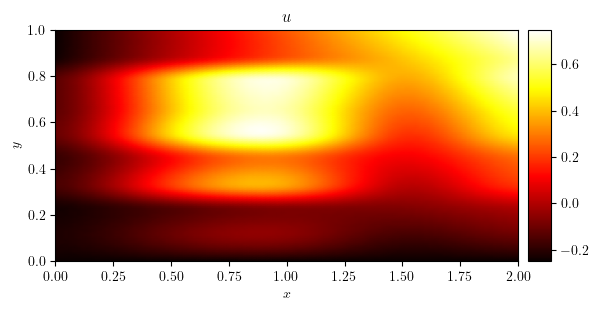

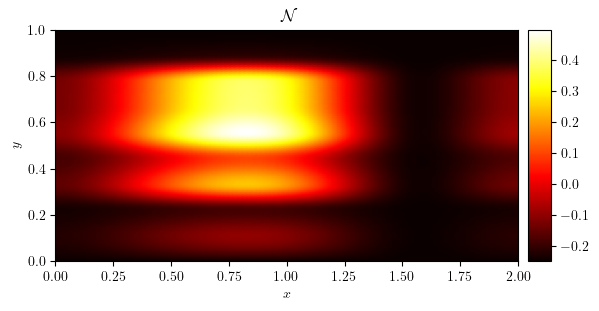

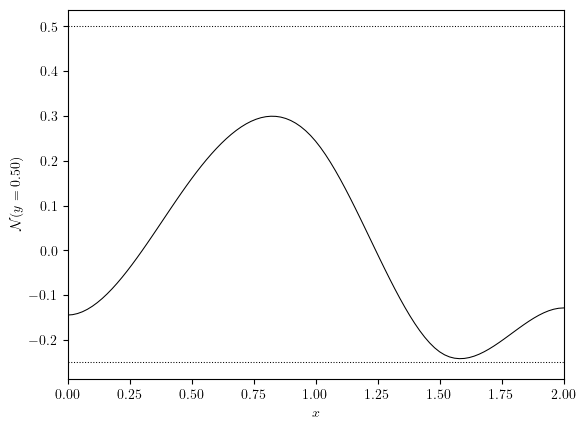

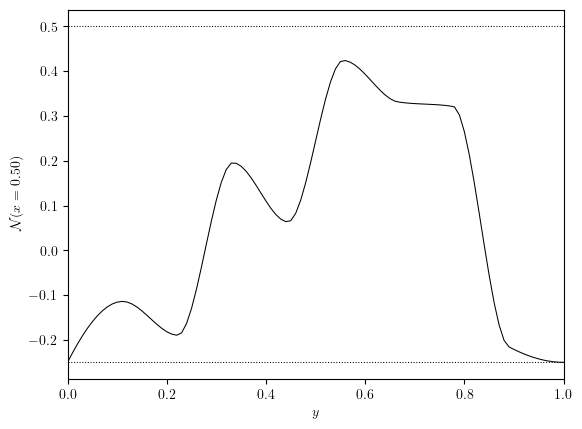

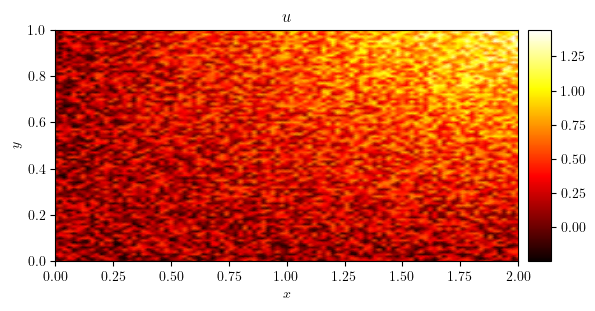

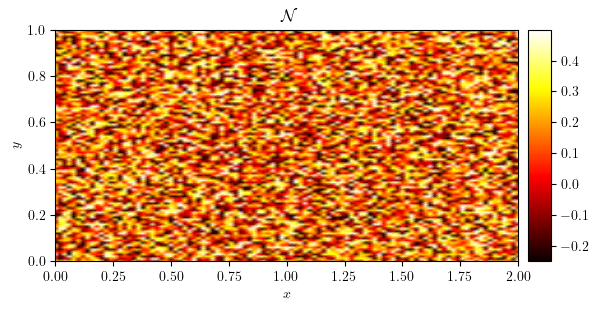

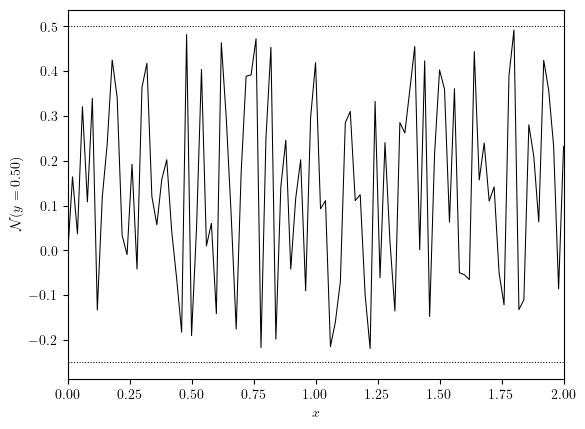

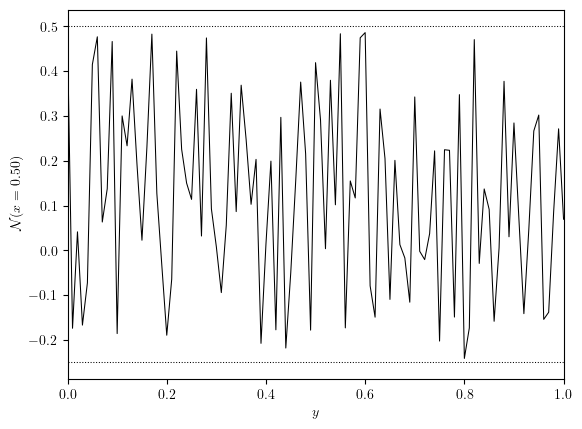

: 

In [ ]:
for perturbation in (noise_perturbation, dofs_perturbation):
    u0 = perturbation.combine_base_noise(fs)
    uBase = perturbation.base(fs)
    uNoise = perturbation.noise(fs)

    print(f'min(N) = {min(uNoise.x.array)}')
    print(f'max(N) = {max(uNoise.x.array)}')

    plot_colormap(u0, title='$u_0$')
    plot_colormap(uNoise, title='$\mathcal{N}$')

    x_axis, uNoise_x, y_value = cross_section(uNoise, 'y', 0.5)
    fig, ax = plot_line((x_axis, uNoise_x), x_label='$x$', y_label=f'$\mathcal{{N}}(y={y_value:.2f})$')
    ax.hlines(eps, 0, Lx, colors='black', linestyles='dotted', linewidths=0.75)

    y_axis, uNoise_y, x_value = cross_section(uNoise, 'x', 0.5)
    fig, ax = plot_line((y_axis, uNoise_y), x_label='$y$', y_label=f'$\mathcal{{N}}(x={y_value:.2f})$')
    ax.hlines(eps, 0, Lx, colors='black', linestyles='dotted', linewidths=0.75)